In [1]:
import pandas as pd
import numpy as np
import utilities.misc as um
import utilities.constants as uc
import pdb
from blp.bdx import bdh,bdp,bds
from fql.fql import Factset_Query
from fql.util import bbg_to_fs, fs_to_bbg,fql_date
from blp.util import get_bbg_usual_col, group_marcap,get_ashare_exchange,load_compo
import feather
import os

#plotly related
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import utilities.display as ud

from datetime import datetime

import utilities.mathematics as umath

from joblib import load, dump

import matplotlib.pyplot as plt




# dont' think IB alone is consistent source of alpha over longer period, maybe worth try more dynamic model
# also if x distribution is distorted then the relationship curve may not be very reliable

In [2]:
path=uc.root_path_data+'connect\\ccass\\'

universe=pd.read_excel(path+'universe.xlsx',sheet_name='quick_tagging_load').set_index('ticker')
cut_off_adv=5

impact_cutoff=0.5

In [3]:
# run the machine learning with consistency weighted flow
to_fit_tidyup=feather.read_dataframe(path+'to_fit_tidyup.feather') # just dropna for quick dirty results
data_loss=len(to_fit_tidyup.dropna())/len(to_fit_tidyup)
print ('data loss after dropna %s' % (1-data_loss))
to_fit_tidyup=to_fit_tidyup.dropna()



windows=[5,10,15,20,25,30,35,40,45,50,55,60]
to_keep=(['date', 'ticker', 'stake_marcap']
        +['ret_%s_rank' % (x) for x in windows]
        +['consistency_%s' % (x) for x in windows]
        +['consistency_%s_rank' % (x) for x in windows]
        +['flow_%s_rank' % (x) for x in windows]
         +['impact_turnover_%s_rank' % (x) for x in windows]
         +['flow_x_consistency_%s_rank' % (x) for x in windows]
        )
to_fit_tidyup=to_fit_tidyup[to_keep].copy()


data loss after dropna 0.05083067308816025


In [4]:
for window in windows:
    to_fit_tidyup['flow_x_consistency_%s' % (window)]=to_fit_tidyup['flow_%s_rank' % (window)]*to_fit_tidyup['consistency_%s_rank' % (window)]
    to_fit_tidyup['flow_x_consistency_rank_%s' % (window)]=to_fit_tidyup['flow_%s_rank' % (window)]*to_fit_tidyup['consistency_%s' % (window)]

In [5]:
# cannot just use stake_marcap, otherwise we will have imbalanced data
to_fit_tidyup['stake_marcap_rank']=to_fit_tidyup.groupby(['date'])['stake_marcap'].rank(pct=True,ascending=True,method='min')

In [6]:
# # run the fitting
# windows=[5,10,15,20,25,30,35,40,45,50,55,60]


# for window_y in windows:
#     y='ret_%s_rank' % (window_y)
#     # xs=(
#     #     ['stake_marcap_rank']  
#     #     +['consistency_%s' % (x) for x in windows]
#     #     +['consistency_%s_rank' % (x) for x in windows] 
#     #     +['flow_%s_rank' % (x) for x in windows] 
#     #     +['impact_turnover_%s_rank' % (x) for x in windows] 
#     #     +['flow_x_consistency_%s_rank' % (x) for x in windows]
#     # )  
    

#     xs=(
#         ['stake_marcap_rank']  
#         # +['consistency_%s' % (window_y)]
#         # +['consistency_%s_rank' % (window_y)] 
#         +['flow_%s_rank' % (window_y)] 
#         +['impact_turnover_%s_rank' % (window_y)] 
#         +['flow_x_consistency_%s_rank' % (window_y)]
#     ) 

#     to_fit_i=to_fit_tidyup[[y]+xs]


#     ebm=umath.get_ebm_initialized()
#     model_i=ebm.fit(to_fit_i[xs],to_fit_i[y])


#     dump(model_i,path+'models_full_data_2\\%s.joblib' % (window_y))
    
#     print ('model_1 %s dumped' % (window_y))

In [7]:
# windows=[5,10,15,20,25,30,35,40,45,50,55,60]

# for window in windows:
#     model_i=load(path+'models_full_data_2\\%s.joblib' % (window))
    
#     coefs, shapes=umath.get_ebm_coef_rank_and_shape(model_i)
    
#     coefs_nice=coefs['importance'].sort_values(ascending=False)
#     fig,axes=plt.subplots(len(coefs_nice.index),1,figsize=(5,2*len(coefs_nice.index)),sharex=True)
    
#     for i,predictor_i in enumerate(coefs_nice.index):
#         shapes[shapes['predictor']==predictor_i]['shape'].plot(ax=axes[i],title=predictor_i)
    
#     fig.savefig(path+'models_full_data_2\\%s.png' % (window),bbox_inches='tight',dpi=200)
#     print ('finished dumping %s' % (window))

In [6]:
# # one big plot
# windows=[5,10,15,20,25,30,35,40,45,50,55,60]

# window_y=windows[0]
# xs=(
#     ['stake_marcap_rank']  
#     # +['consistency_%s' % (window_y)]
#     # +['consistency_%s_rank' % (window_y)] 
#     +['flow_%s_rank' % (window_y)] 
#     +['impact_turnover_%s_rank' % (window_y)] 
#     +['flow_x_consistency_%s_rank' % (window_y)]
# ) 

# fig_importance, axes_importance=plt.subplots(1,len(windows),figsize=(5*len(windows),5),sharey=False,sharex=True)
# fig,axes=plt.subplots(len(xs),len(windows),figsize=(5*len(windows),2*len(xs)),sharex=True,sharey=False)


# for j,window in enumerate(windows):
    
#     model_i=load(path+'models_full_data_2\\%s.joblib' % (window))
#     coefs, shapes=umath.get_ebm_coef_rank_and_shape(model_i)
#     coefs_nice=coefs['importance']
    
#     coefs_nice.plot(ax=axes_importance[j],title=window,kind='barh')
    
#     for i,predictor_i in enumerate(coefs_nice.index):
#         shapes[shapes['predictor']==predictor_i]['shape'].plot(ax=axes[i][j],title=predictor_i)
    

In [20]:
from interpret import show

window=10
model_i=load(path+'models_full_data_2\\%s.joblib' % (window))

show(model_i.explain_global())

<!-- http://127.0.0.1:7001/1527592432584/ -->

In [25]:
model_i.

# do a rolling fitting

In [7]:
# run the fitting
windows=[5,10,15,20,25,30,35,40,45,50,55,60]


for window_y in windows:
    y='ret_%s_rank' % (window_y)
    # xs=(
    #     ['stake_marcap_rank']  
    #     +['consistency_%s' % (x) for x in windows]
    #     +['consistency_%s_rank' % (x) for x in windows] 
    #     +['flow_%s_rank' % (x) for x in windows] 
    #     +['impact_turnover_%s_rank' % (x) for x in windows] 
    #     +['flow_x_consistency_%s_rank' % (x) for x in windows]
    # )  
    

    xs=(
        ['stake_marcap_rank']  
        # +['consistency_%s' % (window_y)]
        # +['consistency_%s_rank' % (window_y)] 
        # +['flow_%s_rank' % (window_y)] 
        # +['impact_turnover_%s_rank' % (window_y)] 
        +['flow_x_consistency_%s_rank' % (window_y)]
    ) 

    
    # one fit for each year
    years=np.arange(2010,2024,1)
    for year in years:
        
        to_fit_i=to_fit_tidyup[(to_fit_tidyup['date']>=datetime(year,1,1)) & (to_fit_tidyup['date']<datetime(year,12,31))][[y]+xs]


        ebm=umath.get_ebm_initialized()
        model_i=ebm.fit(to_fit_i[xs],to_fit_i[y])


        dump(model_i,path+'models_full_data_3\\by_years\\%s_%s.joblib' % (window_y,year))

        print ('model_3 %s dumped for %s' % (window_y,year))

model_3 5 dumped for 2010
model_3 5 dumped for 2011
model_3 5 dumped for 2012
model_3 5 dumped for 2013
model_3 5 dumped for 2014
model_3 5 dumped for 2015
model_3 5 dumped for 2016
model_3 5 dumped for 2017
model_3 5 dumped for 2018
model_3 5 dumped for 2019
model_3 5 dumped for 2020
model_3 5 dumped for 2021
model_3 5 dumped for 2022
model_3 5 dumped for 2023
model_3 10 dumped for 2010
model_3 10 dumped for 2011
model_3 10 dumped for 2012
model_3 10 dumped for 2013
model_3 10 dumped for 2014
model_3 10 dumped for 2015
model_3 10 dumped for 2016
model_3 10 dumped for 2017
model_3 10 dumped for 2018
model_3 10 dumped for 2019
model_3 10 dumped for 2020
model_3 10 dumped for 2021
model_3 10 dumped for 2022
model_3 10 dumped for 2023
model_3 15 dumped for 2010
model_3 15 dumped for 2011
model_3 15 dumped for 2012
model_3 15 dumped for 2013
model_3 15 dumped for 2014
model_3 15 dumped for 2015
model_3 15 dumped for 2016
model_3 15 dumped for 2017
model_3 15 dumped for 2018
model_3 15 dump

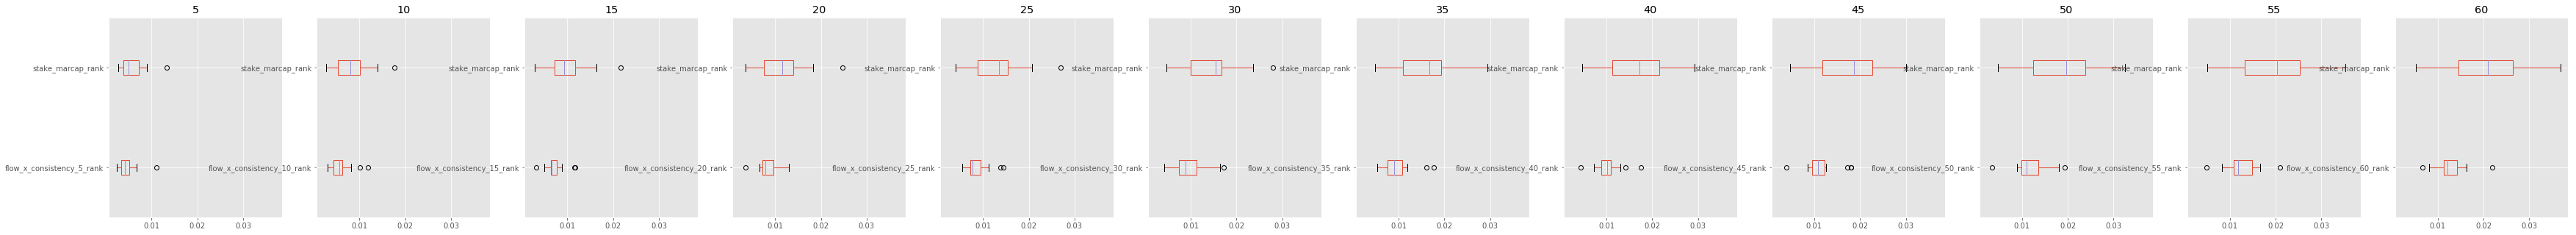

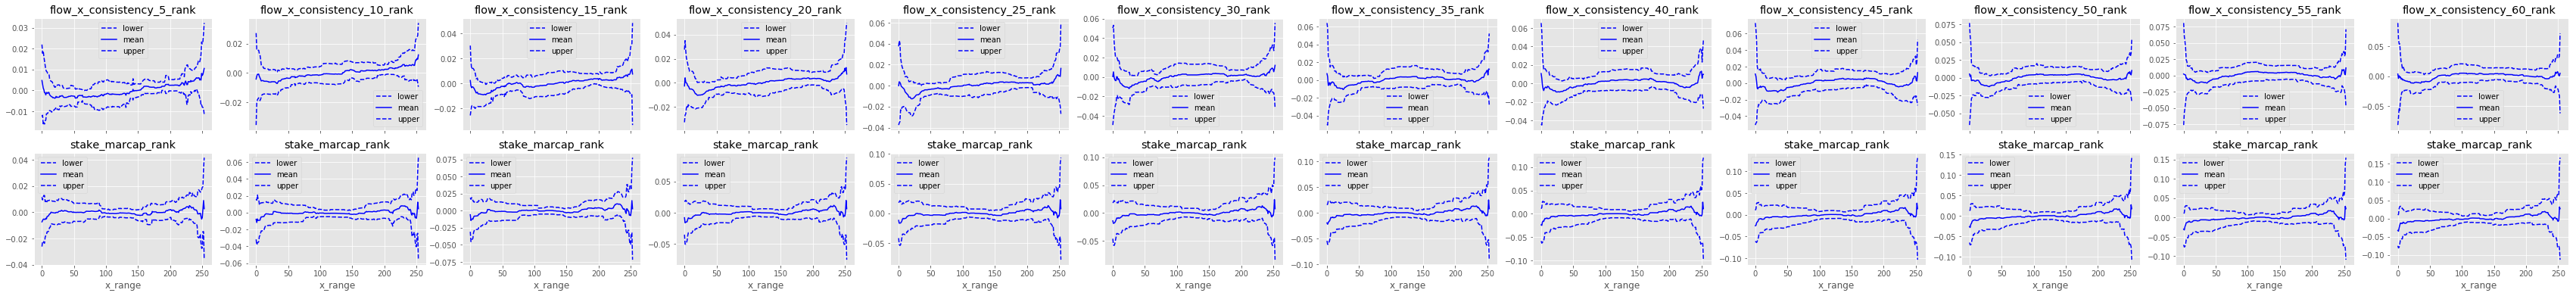

In [9]:
# same one big plot but now do box plot for importance

windows=[5,10,15,20,25,30,35,40,45,50,55,60]
years=np.arange(2010,2024,1)

window_y=windows[0]
xs=(
    ['stake_marcap_rank']  
    # +['consistency_%s' % (window_y)]
    # +['consistency_%s_rank' % (window_y)] 
    # +['flow_%s_rank' % (window_y)] 
    # +['impact_turnover_%s_rank' % (window_y)] 
    +['flow_x_consistency_%s_rank' % (window_y)]
) 



fig_importance, axes_importance=plt.subplots(1,len(windows),figsize=(5*len(windows),5),sharey=False,sharex=True)
fig,axes=plt.subplots(len(xs),len(windows),figsize=(5*len(windows),3*len(xs)),sharex=True,sharey=False)


for j,window in enumerate(windows):
    collector_coefs=[]
    collector_shapes=[]
    for year in years:
        model_i=load(path+'models_full_data_3\\by_years\\%s_%s.joblib' % (window,year))
        coefs, shapes=umath.get_ebm_coef_rank_and_shape(model_i)
        coefs.index.name='feature'
        coefs['year']=year
        shapes['year']=year
        collector_coefs.append(coefs)
        collector_shapes.append(shapes)
    coefs_all=pd.concat(collector_coefs).reset_index().set_index(['year','feature'])['importance'].unstack()
    shapes_all=pd.concat(collector_shapes).reset_index().set_index(['predictor','x_range','year'])['shape']
    
    coefs_all.plot(ax=axes_importance[j],title=window,kind='box',vert=False)

    for i,predictor_i in enumerate(coefs_all.columns):
        shapes_raw=shapes_all.loc[predictor_i].unstack()
        shapes_mean=shapes_raw.mean(1)
        shapes_std=shapes_raw.std(1)
        shapes_to_show=pd.concat([
                                (shapes_mean-shapes_std).rename('lower'),
                                 shapes_mean.rename('mean'),
                                 (shapes_mean+shapes_std).rename('upper')
                                ],axis=1)
        shapes_to_show.plot(ax=axes[i][j],title=predictor_i,style=['--','-','--'],color='blue')

        
fig_importance.savefig(path+'models_full_data_3\\by_years\\importance.png' ,dpi=300)
fig.savefig(path+'models_full_data_3\\by_years\\shapes.png' ,dpi=300)

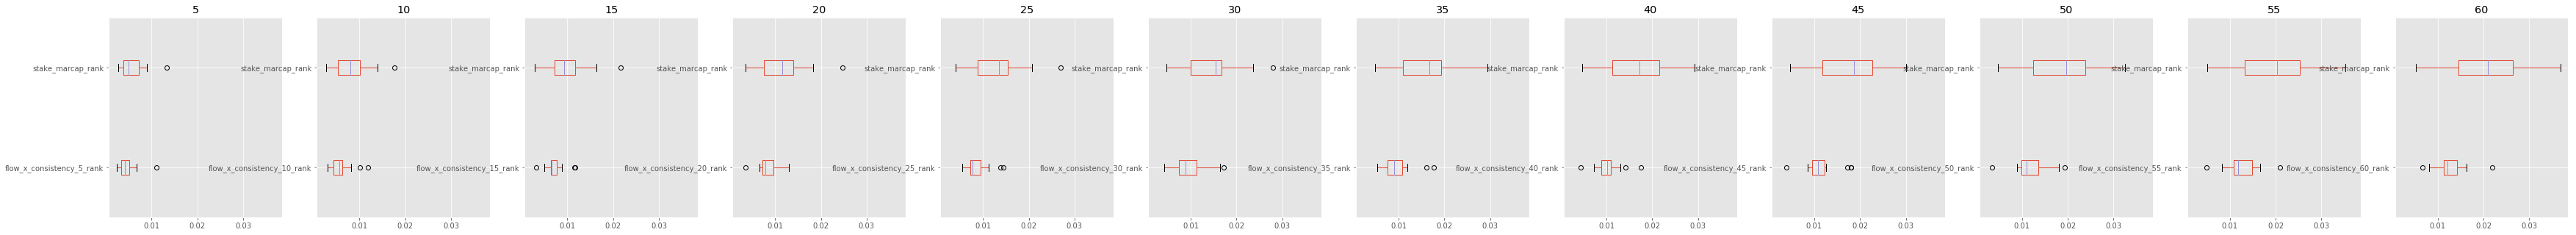

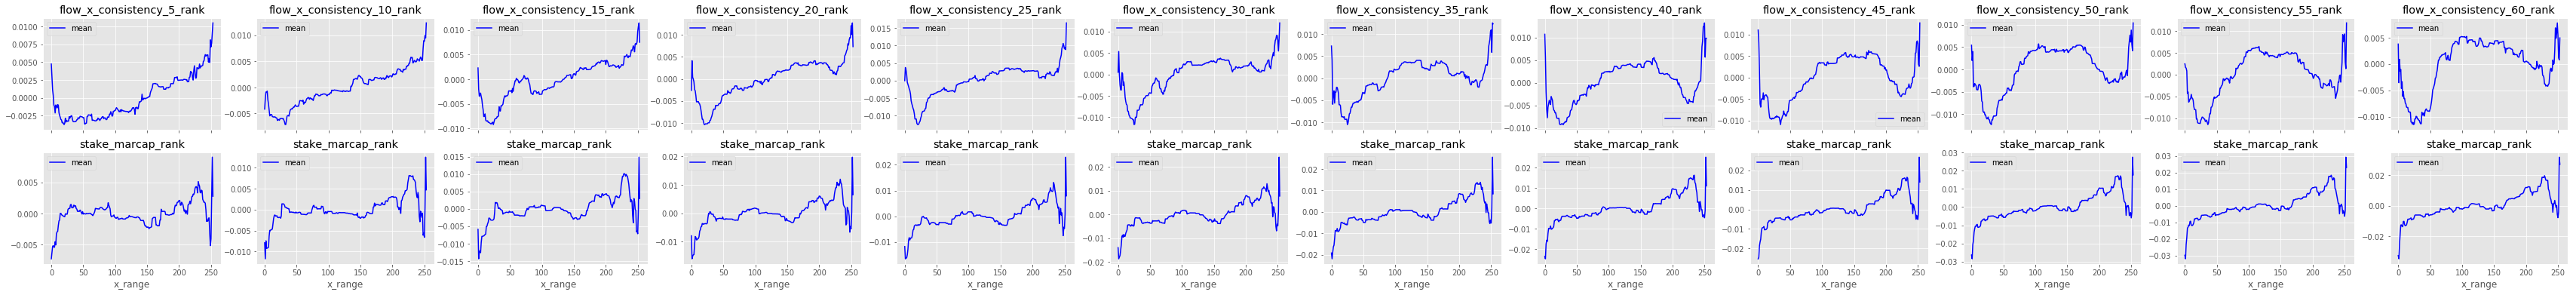

In [11]:
# same one big plot but now do box plot for importance

windows=[5,10,15,20,25,30,35,40,45,50,55,60]
years=np.arange(2010,2024,1)

window_y=windows[0]
xs=(
    ['stake_marcap_rank']  
    # +['consistency_%s' % (window_y)]
    # +['consistency_%s_rank' % (window_y)] 
    # +['flow_%s_rank' % (window_y)] 
    # +['impact_turnover_%s_rank' % (window_y)] 
    +['flow_x_consistency_%s_rank' % (window_y)]
) 



fig_importance, axes_importance=plt.subplots(1,len(windows),figsize=(5*len(windows),5),sharey=False,sharex=True)
fig,axes=plt.subplots(len(xs),len(windows),figsize=(5*len(windows),3*len(xs)),sharex=True,sharey=False)


for j,window in enumerate(windows):
    collector_coefs=[]
    collector_shapes=[]
    for year in years:
        model_i=load(path+'models_full_data_3\\by_years\\%s_%s.joblib' % (window,year))
        coefs, shapes=umath.get_ebm_coef_rank_and_shape(model_i)
        coefs.index.name='feature'
        coefs['year']=year
        shapes['year']=year
        collector_coefs.append(coefs)
        collector_shapes.append(shapes)
    coefs_all=pd.concat(collector_coefs).reset_index().set_index(['year','feature'])['importance'].unstack()
    shapes_all=pd.concat(collector_shapes).reset_index().set_index(['predictor','x_range','year'])['shape']
    
    coefs_all.plot(ax=axes_importance[j],title=window,kind='box',vert=False)

    for i,predictor_i in enumerate(coefs_all.columns):
        shapes_raw=shapes_all.loc[predictor_i].unstack()
        shapes_mean=shapes_raw.mean(1)
        shapes_std=shapes_raw.std(1)
        shapes_to_show=pd.concat([
                               
                                 shapes_mean.rename('mean'),
                                
                                ],axis=1)
        shapes_to_show.plot(ax=axes[i][j],title=predictor_i,color='blue')

        
fig_importance.savefig(path+'models_full_data_3\\by_years\\importance.png' ,dpi=300)
fig.savefig(path+'models_full_data_3\\by_years\\shapes_mean.png' ,dpi=300)

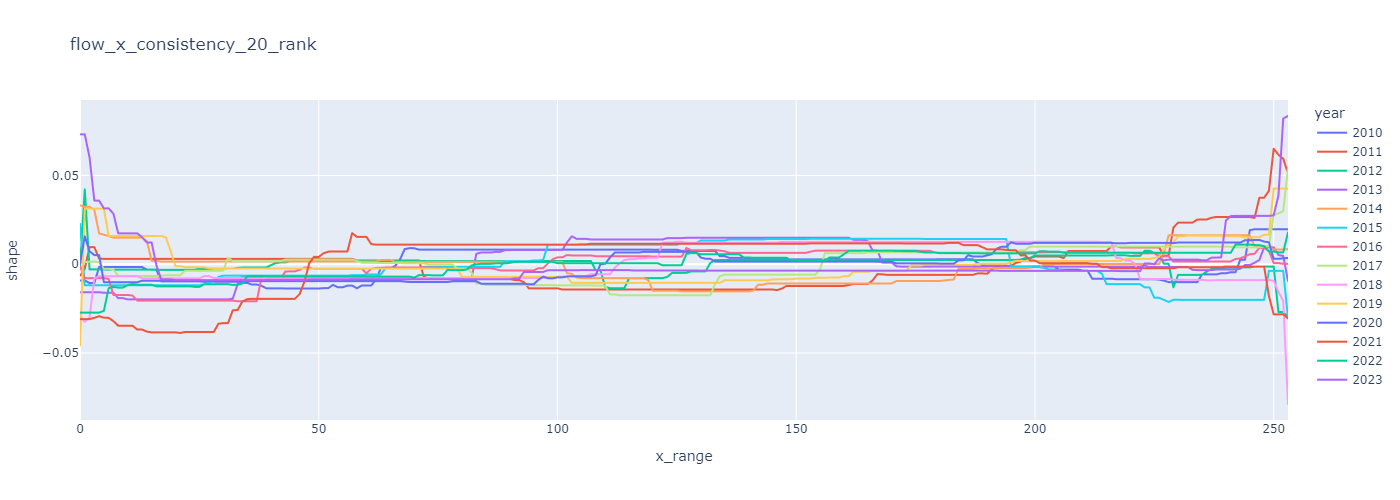

In [24]:
import plotly.express as px

window=20
collector_coefs=[]
collector_shapes=[]
for year in years:
    model_i=load(path+'models_full_data_3\\by_years\\%s_%s.joblib' % (window,year))
    coefs, shapes=umath.get_ebm_coef_rank_and_shape(model_i)
    coefs.index.name='feature'
    coefs['year']=year
    shapes['year']=year
    collector_coefs.append(coefs)
    collector_shapes.append(shapes)
coefs_all=pd.concat(collector_coefs).reset_index().set_index(['year','feature'])['importance'].unstack()
shapes_all=pd.concat(collector_shapes).reset_index().set_index(['predictor','x_range','year'])['shape']


field='flow_x_consistency_%s_rank' % (window)
fig=px.line(shapes_all.loc[field].reset_index(),x='x_range',y='shape',color='year',title=field)
fig.update_layout(width=750,height=500)
fig.show()

